# Load Data

In [2]:
import numpy as np

# Load data
X = np.load("olivetti_faces.npy")  # shape: (400, 64, 64)
y = np.load("olivetti_faces_target.npy")  # shape: (400,)

# Normalize and reshape for CNN
X = X.astype("float32")/255.0
X = np.expand_dims(X, -1)  # shape: (400, 64, 64, 1)

# VAE Architecture

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

# -----------------
# Split into train/val sets
# -----------------
X_train, X_val = train_test_split(X, test_size=0.1, random_state=42)

# -----------------
# Create batched datasets
# -----------------
BATCH_SIZE = 32
train_dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size=len(X_train)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(X_val).batch(BATCH_SIZE)

# -----------------
# 2. Encoder Definition
# -----------------
latent_dim = 64
encoder_inputs = layers.Input(shape=(64, 64, 1))
x = layers.Conv2D(32, 3, strides=2, padding="same", activation="relu")(encoder_inputs)
x = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

def sample_z(args):
    mean, log_var = args
    eps = tf.random.normal(shape=tf.shape(mean))
    return mean + tf.exp(0.5 * log_var) * eps

z = layers.Lambda(sample_z, name="z")([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# -----------------
# 3. Decoder Definition
# -----------------
latent_inputs = layers.Input(shape=(latent_dim,))
x = layers.Dense(16*16*64, activation="relu")(latent_inputs)
x = layers.Reshape((16, 16, 64))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, padding="same", activation="sigmoid")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")

# -----------------
# 4. VAE Class with Custom train_step & test_step
# -----------------
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        x = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x, training=True)
            x_pred = self.decoder(z, training=True)

            recon_loss = tf.keras.backend.binary_crossentropy(
                tf.reshape(x, [tf.shape(x)[0], -1]),
                tf.reshape(x_pred, [tf.shape(x_pred)[0], -1])
            )
            recon_loss = tf.reduce_sum(recon_loss, axis=1)
            recon_loss = tf.reduce_mean(recon_loss)

            kl_loss = -0.5 * tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
            )
            kl_loss = tf.reduce_mean(kl_loss)

            loss = recon_loss + kl_loss

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

    def test_step(self, data):
        x = data
        z_mean, z_log_var, z = self.encoder(x, training=False)
        x_pred = self.decoder(z, training=False)

        recon_loss = tf.keras.backend.binary_crossentropy(
            tf.reshape(x, [tf.shape(x)[0], -1]),
            tf.reshape(x_pred, [tf.shape(x_pred)[0], -1])
        )
        recon_loss = tf.reduce_sum(recon_loss, axis=1)
        recon_loss = tf.reduce_mean(recon_loss)

        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        loss = recon_loss + kl_loss
        return {"loss": loss, "recon_loss": recon_loss, "kl_loss": kl_loss}

    def call(self, inputs):
        _, _, z = self.encoder(inputs)
        return self.decoder(z)

# -----------------
# 5. Compile & Train in batches
# -----------------
vae = VAE(encoder, decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=None, run_eagerly=True)

In [4]:
vae.fit(train_dataset, epochs=100, validation_data=val_dataset)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 217ms/step - kl_loss: 25.2473 - loss: 2016.8234 - recon_loss: 1991.5760 - val_kl_loss: 214.2042 - val_loss: 338.2794 - val_recon_loss: 124.0752
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step - kl_loss: 145.3050 - loss: 258.0487 - recon_loss: 112.7437 - val_kl_loss: 15.5909 - val_loss: 116.5484 - val_recon_loss: 100.9576
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - kl_loss: 5.2794 - loss: 109.2336 - recon_loss: 103.9542 - val_kl_loss: 3.4634 - val_loss: 98.3416 - val_recon_loss: 94.8782
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - kl_loss: 4.7644 - loss: 104.1444 - recon_loss: 99.3801 - val_kl_loss: 4.3463 - val_loss: 89.7515 - val_recon_loss: 85.4052
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - kl_loss: 3.3944 - loss: 98.1940 - recon_loss: 94.7997 - val_kl_loss: 3.3122 - val_loss: 87.3082 - val_recon_loss: 83.9959
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - kl_loss: 3.5741 - loss: 87.2180 - recon_l

# Output

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step


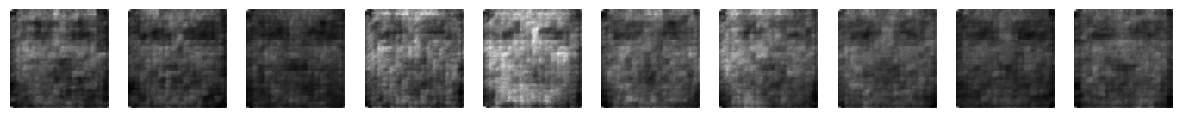

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Number of images to generate
n_images = 10

# Sample random points from a standard normal distribution
random_latent_vectors = np.random.normal(size=(n_images, latent_dim))

# Decode them to images
generated_images = decoder.predict(random_latent_vectors)

# Plot results
plt.figure(figsize=(15, 3))
for i in range(n_images):
    ax = plt.subplot(1, n_images, i + 1)
    plt.imshow(generated_images[i].squeeze(), cmap="gray")
    plt.axis("off")
plt.show()


# Save model

In [6]:
# -----------------
# 6. Save Models
# -----------------
vae.encoder.save("vae_encoder.h5")
vae.decoder.save("vae_decoder.h5")
vae.save("vae_full.h5")  # saves only the VAE wrapper (optional)

print("Saved: vae_encoder.h5, vae_decoder.h5, vae_full.h5")


Saved: vae_encoder.h5, vae_decoder.h5, vae_full.h5


# Interface

In [ ]:
import gradio as gr
import cv2

# Load trained models
decoder = tf.keras.models.load_model("vae_decoder.h5", compile=False)
encoder = tf.keras.models.load_model("vae_encoder.h5", compile=False)

def reconstruct_image(img):
    img = cv2.resize(img, (64, 64)) / 255.0
    img = np.expand_dims(img, axis=(0, -1))
    z_mean, _, _ = encoder.predict(img)
    reconstructed = decoder.predict(z_mean)[0]
    return reconstructed

iface = gr.Interface(
    fn=reconstruct_image,
    inputs=gr.Image(shape=(64,64), image_mode="L"),
    outputs=gr.Image(shape=(64,64), image_mode="L"),
    title="Olivetti Faces VAE"
)

iface.launch()
